# Gene Regulatory Network Prediction of Yeast Network
The task:
Predict which transcription factors affects genes (For now this is non-tf)

In [8]:
# Import stuff
import pandas as pd
import numpy as np
import grn_preds

In [9]:
# Get expression data
ko_df = pd.read_csv('../dataset/yeast_networks/expression/KO.txt', sep='\t').set_index('Gene')
nv_df = pd.read_csv('../dataset/yeast_networks/expression/NatVar.txt', sep='\t').set_index('Gene')
stress_df = pd.read_csv('../dataset/yeast_networks/expression/Stress.txt', sep='\t').set_index('Name')

# Get Transcription Factors
ko_tf = pd.read_csv('../dataset/yeast_networks/expression/KO_TF_names.txt', sep='\t', header=None)
ko_tf.columns = ['TF']

nv_tf = pd.read_csv('../dataset/yeast_networks/expression/NatVar_TF_names.txt', sep='\t', header=None)
nv_tf.columns = ['TF']

stress_tf = pd.read_csv('../dataset/yeast_networks/expression/Stress_TF_names.txt', sep='\t', header=None)
stress_tf.columns = ['TF']

# Note that there are different gene list for each df, so we will use ko as test for now.

In [10]:
# Generate gold dataset / gold truth vector
ko_gold = grn_preds.generate_gold_dataset(['../dataset/yeast_networks/gold/MacIsaac2.KO.txt', 
                                 '../dataset/yeast_networks/gold/YEASTRACT_Type2.KO.txt', 
                                 '../dataset/yeast_networks/gold/YEASTRACT_Count3.KO.txt'])

In [11]:
# Start Pipeline: Generate existing truth edges
ko_main_df = grn_preds.generate_possible_edges(ko_tf.loc[:, 'TF'], ko_df)
ko_main_df = grn_preds.populate_actual_column(ko_main_df, ko_gold)

In [ ]:
# Use only 10 random target genes in the ko_df, then use all TF to predict
# Get 10 random target genes
sampled_target = list(ko_df.sample(30).index)

# Get ground truth for these target genes
sampled_gold_df = ko_gold[ko_gold.loc[:, 'Target'].isin(sampled_target)]
sampled_ko_main_df = ko_main_df[ko_main_df.loc[:, 'Target'].isin(sampled_target)]

# Populate actual columns
sampled_ko_main_df = grn_preds.populate_actual_column(sampled_ko_main_df, ko_gold)

# Predict
for target in sampled_target:
    print(target)
    lasso_edges, lasso_scores = grn_preds.grn_lasso(target, ko_tf.loc[:, 'TF'], ko_df, alphas = [0.001, 0.01, 0.1, 1, 10, 100], cv = 5)
    rf_edges, rf_scores = grn_preds.grn_regforest(target, ko_tf.loc[:, 'TF'], ko_df, n_estimators = 100, max_depth = 8, bootstrap = True, min_samples_leaf = 10, n_jobs = -1)
    svr_lin_edges, svr_lin_scores = grn_preds.grn_svr(target, ko_tf.loc[:, 'TF'], ko_df, kernel='linear')
#     svr_rbf_edges, svr_rbf_scores = grn_preds.grn_svr(target, ko_tf.loc[:, 'TF'], ko_df, kernel='rbf')
#     svr_poly_edges, svr_poly_scores = grn_preds.grn_svr(target, ko_tf.loc[:, 'TF'], ko_df, kernel='poly')
    
    
    sampled_ko_main_df.loc[lasso_edges, 'Lasso scores'] = abs(lasso_scores)
    sampled_ko_main_df.loc[rf_edges, 'Regforest scores'] = rf_scores
    sampled_ko_main_df.loc[svr_lin_edges, 'SVR Linear scores'] = abs(svr_lin_scores)
#     sampled_ko_main_df.loc[svr_rbf_edges, 'SVR RBF scores'] = abs(svr_rbf_scores)
#     sampled_ko_main_df.loc[svr_poly_edges, 'SVR Polynomial scores'] = abs(svr_poly_scores)


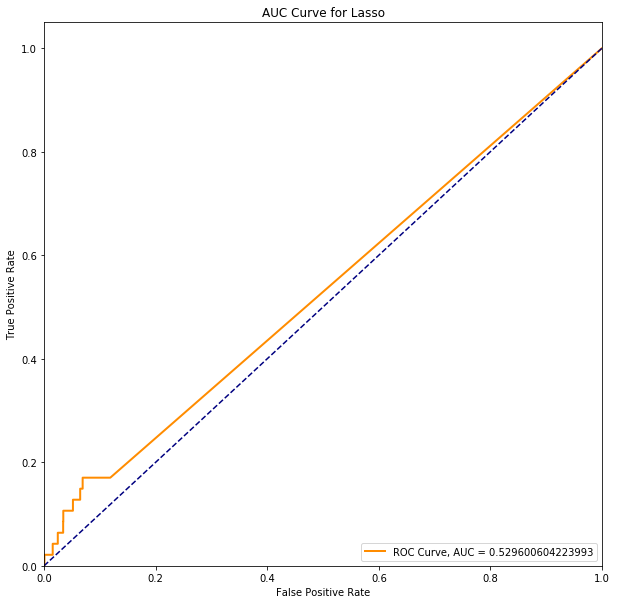

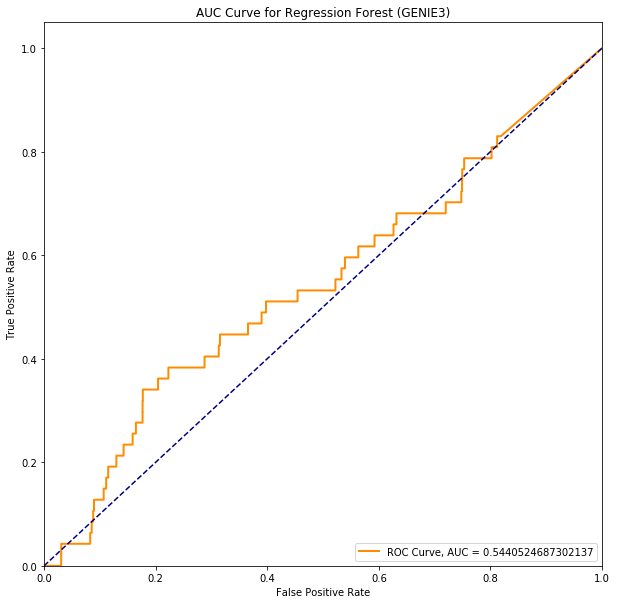

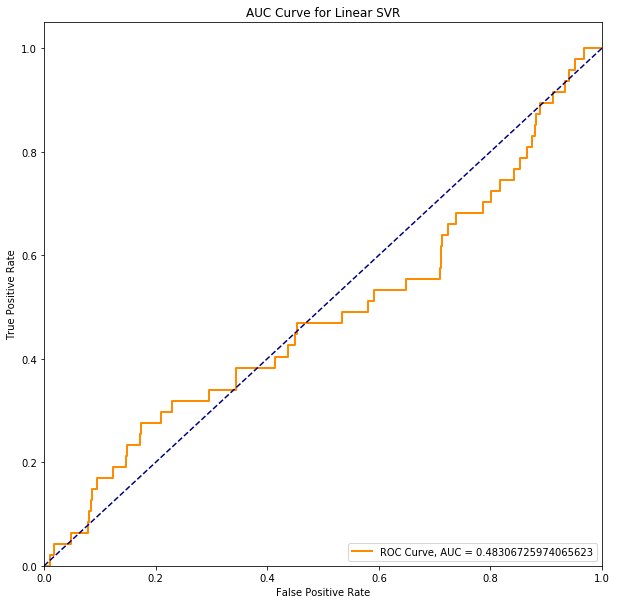

0.48306725974065623

In [13]:
# Generate auroc for lasso and regforest
grn_preds.generate_auroc(sampled_ko_main_df.loc[:, 'Actual'], sampled_ko_main_df.loc[:, 'Lasso scores'], 'AUC Curve for Lasso')
grn_preds.generate_auroc(sampled_ko_main_df.loc[:, 'Actual'], sampled_ko_main_df.loc[:, 'Regforest scores'], 'AUC Curve for Regression Forest (GENIE3)')
grn_preds.generate_auroc(sampled_ko_main_df.loc[:, 'Actual'], sampled_ko_main_df.loc[:, 'SVR Linear scores'], 'AUC Curve for Linear SVR')

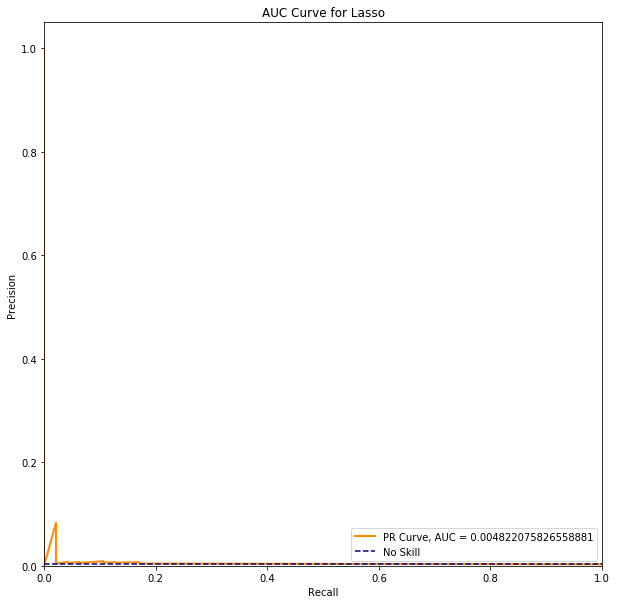

average precision score: 0.005323255637840158
average precision score: 0.0036239679183456305
average precision score: 0.003366101186404415


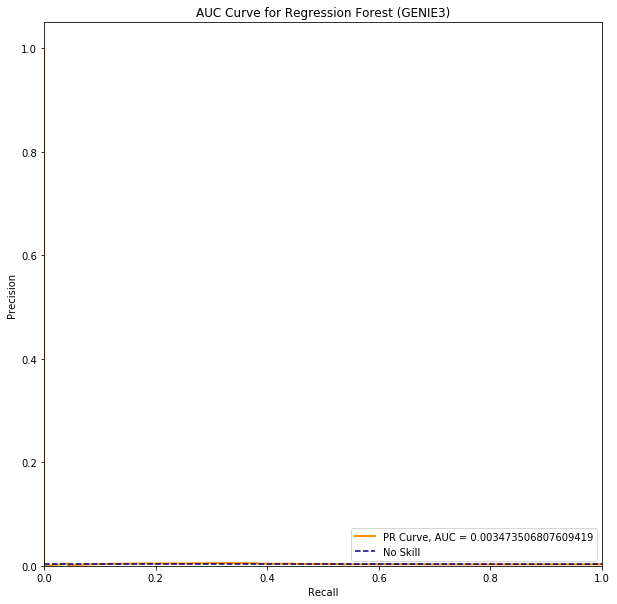

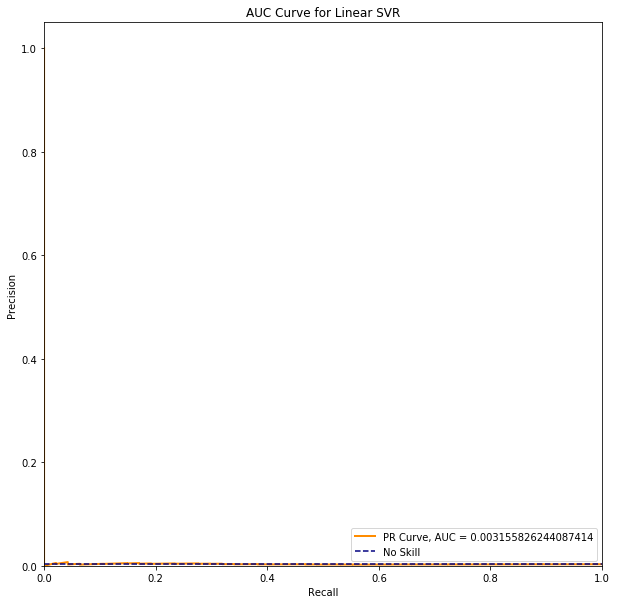

(0.003155826244087414,)

In [14]:
# Generate auroc for lasso and regforest
grn_preds.generate_aupr(sampled_ko_main_df.loc[:, 'Actual'], sampled_ko_main_df.loc[:, 'Lasso scores'], 'AUC Curve for Lasso')
grn_preds.generate_aupr(sampled_ko_main_df.loc[:, 'Actual'], sampled_ko_main_df.loc[:, 'Regforest scores'], 'AUC Curve for Regression Forest (GENIE3)')
grn_preds.generate_aupr(sampled_ko_main_df.loc[:, 'Actual'], sampled_ko_main_df.loc[:, 'SVR Linear scores'], 'AUC Curve for Linear SVR')

In [ ]:
# Use all dataset, generate scores for all genes, then get AUC
for target in ko_df.index:
    lasso_edges, lasso_scores = grn_preds.grn_lasso(target, ko_tf.loc[:, 'TF'], ko_df, alphas = [0.001, 0.01, 0.1, 1, 10, 100], cv = 5)
    rf_edges, rf_scores = grn_preds.grn_regforest(target, ko_tf.loc[:, 'TF'], ko_df, n_estimators = 100, max_depth = 8, bootstrap = True, min_samples_leaf = 10, n_jobs = -1)
    svr_lin_edges, svr_lin_scores = grn_preds.grn_svr(target, ko_tf.loc[:, 'TF'], ko_df, kernel='linear')
    
    ko_main_df.loc[lasso_edges, 'Lasso scores'] = abs(lasso_scores)
    ko_main_df.loc[rf_edges, 'Regforest scores'] = rf_scores
    ko_main_df.loc[svr_lin_edges, 'SVR Linear scores'] = abs(svr_lin_scores)    

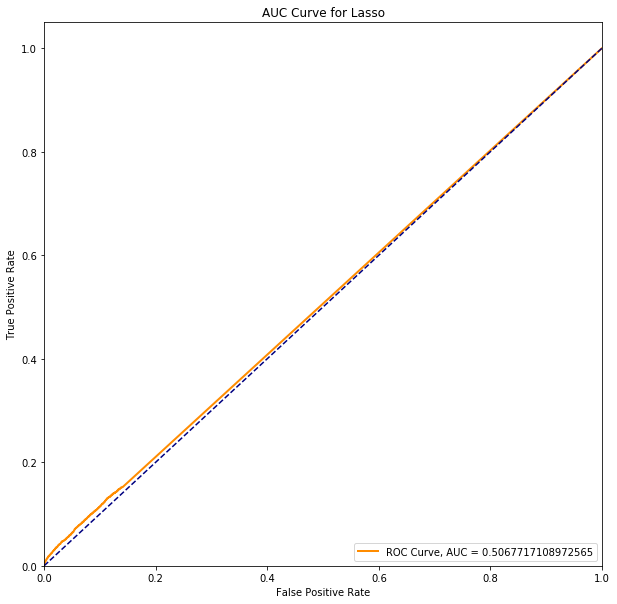

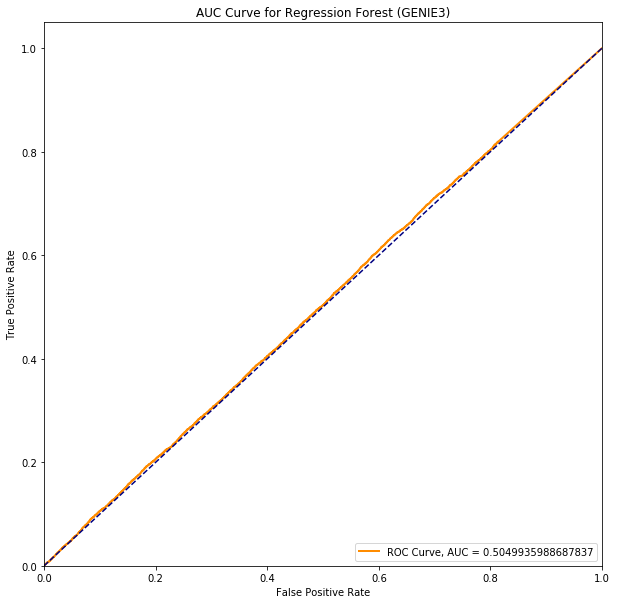

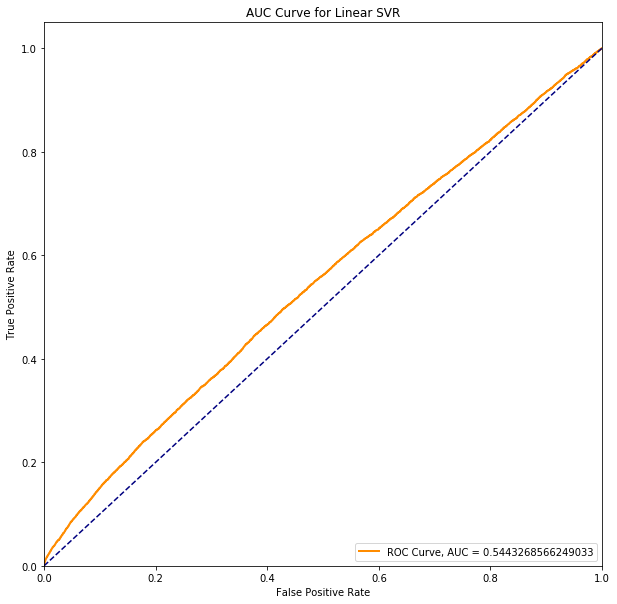

0.5443268566249033

In [13]:
# Generate auroc for lasso and regforest
grn_preds.generate_auroc(ko_main_df.loc[:, 'Actual'], ko_main_df.loc[:, 'Lasso scores'], 'AUC Curve for Lasso')
grn_preds.generate_auroc(ko_main_df.loc[:, 'Actual'], ko_main_df.loc[:, 'Regforest scores'], 'AUC Curve for Regression Forest (GENIE3)')
grn_preds.generate_auroc(ko_main_df.loc[:, 'Actual'], ko_main_df.loc[:, 'SVR Linear scores'], 'AUC Curve for Linear SVR')

In [14]:
grn_preds.FinallyItIsDone